#Procesamiento y Clasificación de Datos
##Tarea 3 
###Gloria Samanta Servín García 1731703
###5 Junio 2022

# Ventas históricas de boletos de cine

Se trabajará con un data set que cuenta con el total de ventas de boletos de cine por tipo de película, código del cine y fecha con el propósito de predecir las ventas a futuro a identificar patrones dentro de la serie de tiempo.

> Bloque con sangría



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

from dask.distributed import Client
from fbprophet.diagnostics import cross_validation

from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [4]:
#Obtenemos nuestros datos desde Drive
from google.colab import drive
drive.mount('/content/drive')
ticket = pd.read_csv('/content/drive/MyDrive/MCD/Procesamiento/cinemaTicket_Ref.csv', usecols = ['total_sales', 'date'])
ticket.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,total_sales,date
0,3900000,2018-05-05
1,3360000,2018-05-05
2,2560000,2018-05-05
3,1200000,2018-05-05
4,1200000,2018-05-05


Nos concentramos únicamente en las variables de interés para poder generar el pronóstico, que en este caso vendrían siendo el total de las ventas y la fecha.

In [5]:
ticket['date'] = pd.to_datetime(ticket['date'], errors='coerce')
ticket

,total_sales,date
0,3900000,2018-05-05
1,3360000,2018-05-05
2,2560000,2018-05-05
3,1200000,2018-05-05
4,1200000,2018-05-05
...,...,...
142519,1320000,2018-11-04
142520,1200000,2018-11-04
142521,1060000,2018-11-04
142522,600000,2018-11-04


Nos aseguramos que todas las fechas mantengan el mismo formato aplicando errors= 'coerce'

In [6]:
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   total_sales  142524 non-null  int64         
 1   date         142524 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 MB


Se revisa el tipo de formato de nuestras columnas para poder proceder

In [7]:
ticket.describe(include = 'all')

,total_sales,date
count,1.425240e+05,142524
unique,NaN,234
top,NaN,2018-05-15 00:00:00
freq,NaN,790
first,NaN,2018-02-21 00:00:00
last,NaN,2018-11-04 00:00:00
mean,1.234728e+07,NaN
std,3.065486e+07,NaN
min,2.000000e+04,NaN
25%,1.260000e+06,NaN


En la tabla podemos ver una breve descripción de valores estadístico de la columna de las ventas, se identifican su media, valor mínimo y máximo así como los valores de los cuantiles

# Data utilizando Prophet
Prophet es un procedimiento para pronosticar datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos faltantes y los cambios en la tendencia, y por lo general maneja bien los valores atípicos.

Se utiliza Prophet en esta actividad ya que es posible notar que todo está preparado para ser fácil de usar sin ningún cuidado especial sobre el manejo de datos de series de tiempo, además que al momento de querer crear una predicción futura para la serie de tiempo con sólo dar la duración del período futuro le proporcionará el marco de datos necesario.

In [8]:
total_sales = ticket.copy()
total_sales.columns = ['y', 'ds']
total_sales

,y,ds
0,3900000,2018-05-05
1,3360000,2018-05-05
2,2560000,2018-05-05
3,1200000,2018-05-05
4,1200000,2018-05-05
...,...,...
142519,1320000,2018-11-04
142520,1200000,2018-11-04
142521,1060000,2018-11-04
142522,600000,2018-11-04


Se crea una copia de nuestra tabla original para comenzar a trabajar con la serie de tiempo, renombrando la columna de ventas como "y" y la fecha a "ds".

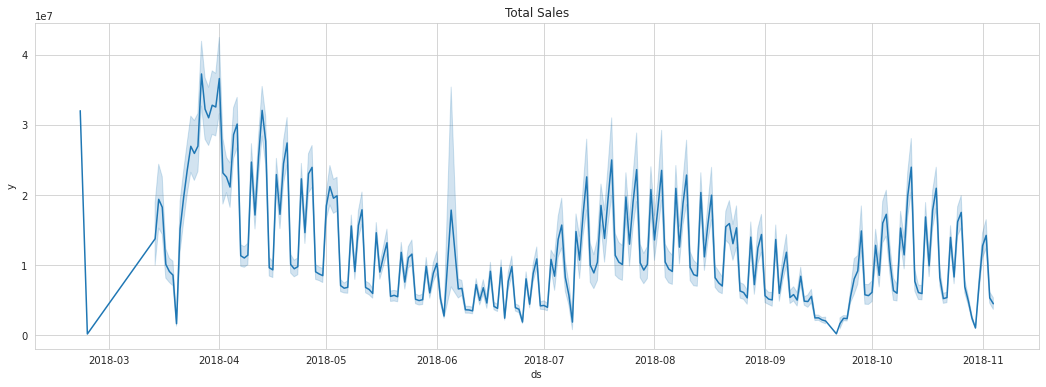

In [9]:
plt.figure(figsize = (18,6))
sns.lineplot(data=total_sales, x="ds", y="y")
plt.title('Total Sales')
plt.show()

En una primera instancia, es fácil notar en la gráfica que las ventas durante el primer semestre del año 2018 fueron mayores a comparación del segundo. A simple vista no se identifica alguna tendencia clara en su comportamiento.

# Primer Modelo
Prophet ajusta estacionalidades aditivas, lo que significa que el efecto de la estacionalidad se agrega a la tendencia para obtener el pronóstico.

In [10]:
m1 = Prophet()
m1.fit(total_sales)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future1 = m1.make_future_dataframe(periods=150,freq='D')
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2018-02-21,-7.331401e+07,5.770378e+06,-3.258319e+07
1,2018-02-23,-5.940351e+07,1.639735e+07,-2.179613e+07
2,2018-03-14,-3.063884e+07,4.632192e+07,6.158855e+06
3,2018-03-15,-2.522745e+07,4.833331e+07,1.261818e+07
4,2018-03-16,-1.973041e+07,5.458344e+07,1.694591e+07
...,...,...,...,...
379,2019-03-30,-1.282792e+08,1.713851e+08,2.438491e+07
380,2019-03-31,-1.264359e+08,1.697086e+08,2.307017e+07
381,2019-04-01,-1.330033e+08,1.752866e+08,2.269446e+07
382,2019-04-02,-1.151063e+08,1.828003e+08,3.100617e+07


En la tabla generada por Prophet nombramos yhat_lower/yhat_upper a los intervalos de incertidumbre e identificamos yhat como el pronóstico generado para nuestra y

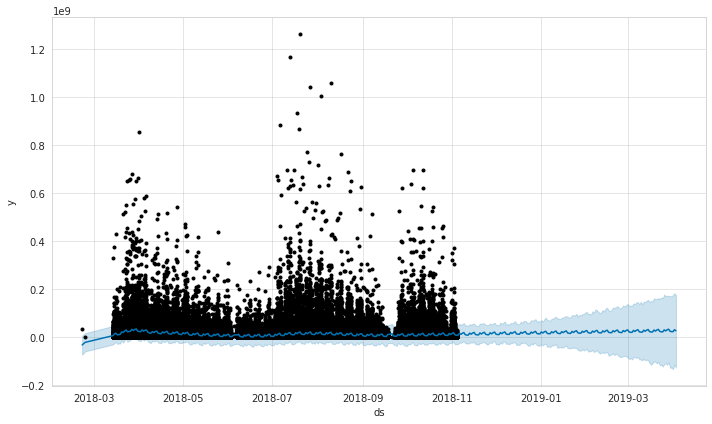

In [13]:
fig_fcast1 = m1.plot(forecast1)

Con el apoyo visual del gráfico para las predicciones, podemos decir que la implementación de este primer modelo aditivo no es adecuado para la creación de pronósticos ya que la fluctuación prevista debido a la estacionalidad es constante a lo largo de los meses.

# Segundo Modelo
En esta alternativa se apuesta por un acercamiento multiplicativo

In [14]:
m2 = Prophet(seasonality_mode='multiplicative')
m2.fit(total_sales)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future2 = m2.make_future_dataframe(periods=150,freq='D')
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2018-02-21,-6.327789e+07,1.222332e+07,-2.534325e+07
1,2018-02-23,-7.497349e+07,9.286103e+05,-3.476818e+07
2,2018-03-14,-3.254116e+07,4.837745e+07,7.296654e+06
3,2018-03-15,-2.696565e+07,4.801185e+07,1.200988e+07
4,2018-03-16,-2.323475e+07,5.315570e+07,1.627054e+07
...,...,...,...,...
379,2019-03-30,-9.656230e+07,1.436019e+08,2.561592e+07
380,2019-03-31,-8.241034e+07,1.242780e+08,2.248760e+07
381,2019-04-01,-7.869542e+07,1.170671e+08,2.085147e+07
382,2019-04-02,-1.410080e+08,2.187263e+08,4.016863e+07


Nuevamente, en la tabla generada por Prophet nombramos yhat_lower/yhat_upper a los intervalos de incertidumbre e identificamos yhat como el pronóstico generado para nuestra y

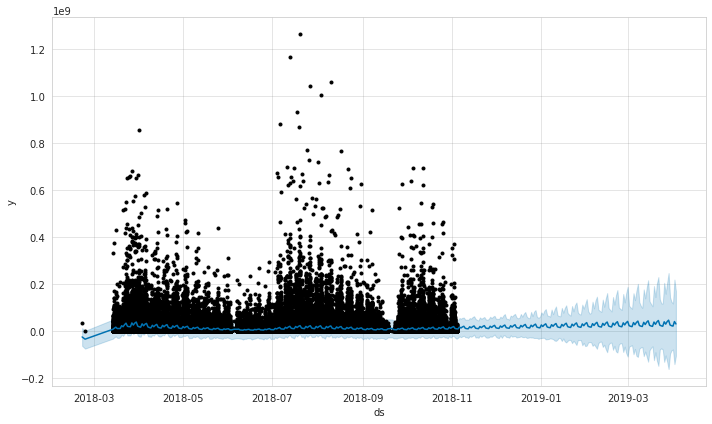

In [16]:
fig_fcast2 = m2.plot(forecast2)

En este caso, es posible notar como la estacionalidad va aunmentando con el tiempo

# Cambios de tendencia 
Prophet especifica 25 puntos de cambio potenciales que se colocan uniformemente en el primer 80% de la serie temporal.

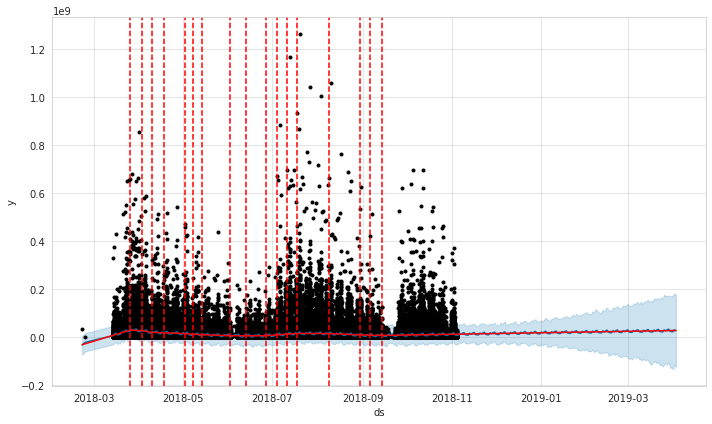

In [17]:
fig_trend1 = m1.plot(forecast1)
a = add_changepoints_to_plot(fig_trend1.gca(),m1,forecast1)

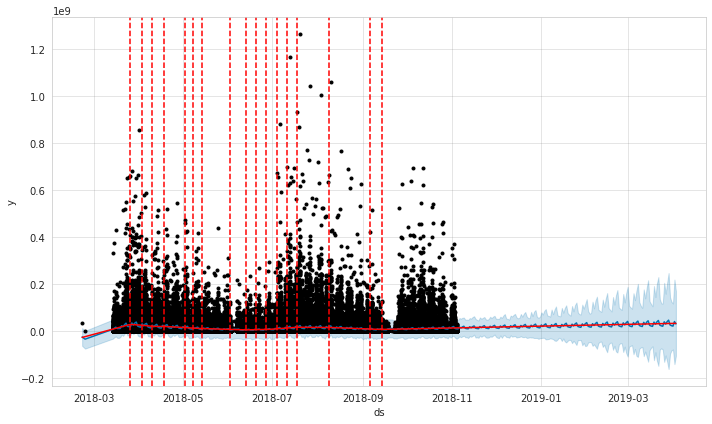

In [18]:
fig_trend2 = m2.plot(forecast2)
a = add_changepoints_to_plot(fig_trend2.gca(),m2,forecast2)

#Componentes de los Modelos

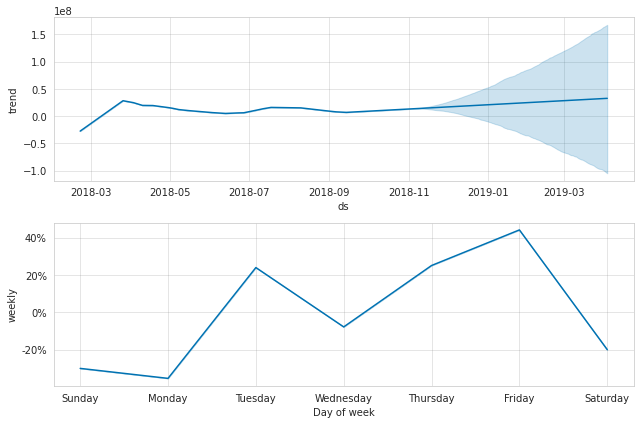

In [46]:
forecast2 = m2.predict(future2)
fig_model2 = m2.plot_components(forecast2)

Podemos notar que los días Martes tienen un pico en las ventas a lo que lo podemos relacionar con las promociones que los cines suelen implementar con el propósito de incrementar sus ventas entre semana. De jueves a viernes se tiene un crecimiento para proceder a decaer de forma considerable el día sábado.

# Recursos utilizados
https://www.kaggle.com/datasets/arashnic/cinema-ticket?select=cinemaTicket_Ref.csv

https://medium.com/swlh/facebook-prophet-426421f7e331

https://pypi.org/project/prophet/